<a href="https://colab.research.google.com/github/BiancaHill/Data-Science/blob/main/BianHillU5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project: Making a Generalized Linear Model (1 predictor)




I decided to do my project about penguins, specifically comparing flipper length to body mass, because penguins are cool and fun and who wouldn't want to do a project about penguins. Based of my very little knowledge about penguins, I'm assuming that this data should be relatively linear since it makes sense that the large the penguin, the large it's flippers will be.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

Loading in my data

In [ ]:
url_peng = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
peng = pd.read_csv(url_peng)
peng

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


I realized that there were places in my data where it just said NA which would mess up my data so I used the dropna feature to get rid of them.

In [ ]:
peng.dropna(inplace=True)

In [ ]:
peng

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


<Axes: xlabel='body_mass', ylabel='flipper_length'>

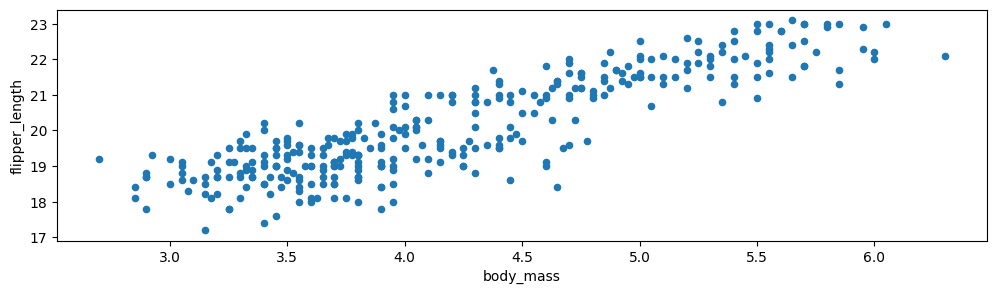

In [ ]:
peng.plot(x="body_mass", y="flipper_length", figsize=(12, 3), kind="scatter")

Scatter plot looks pretty linear already, but with lots of variance that might mess up the model a bit.

I started by using a normal distribution just because it seemed like the simplist and it would give me a better understanding of what my model should look like in the end.

In [ ]:
with pm.Model() as model_peng:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * peng.body_mass)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 5)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=peng.flipper_length)

    #inference data object
    idata_peng = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

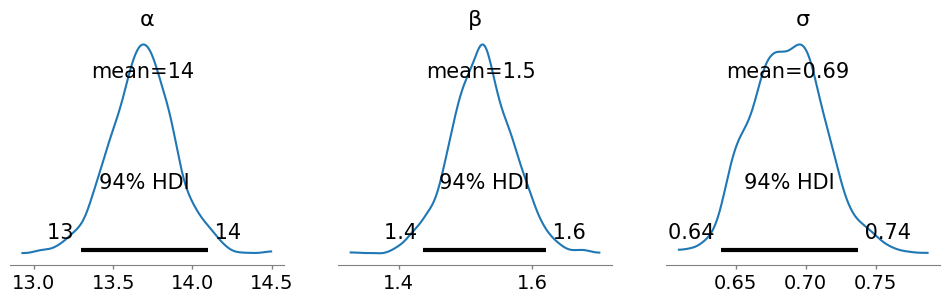

In [ ]:
az.plot_posterior(idata_peng, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'flipper_length')

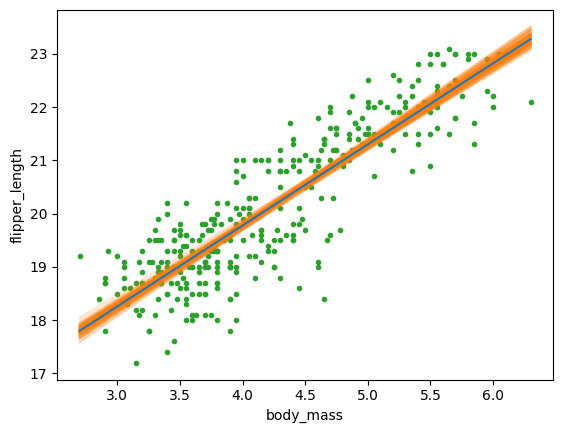

In [ ]:
posterior = az.extract(idata_peng, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(peng.body_mass.min(), peng.body_mass.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(peng.body_mass, peng.flipper_length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("body_mass")
ax.set_ylabel("flipper_length")


The posterior seems to fit the data pretty well, that's a good sign

In [ ]:
pm.sample_posterior_predictive(idata_peng, model=model_peng,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'flipper_length')

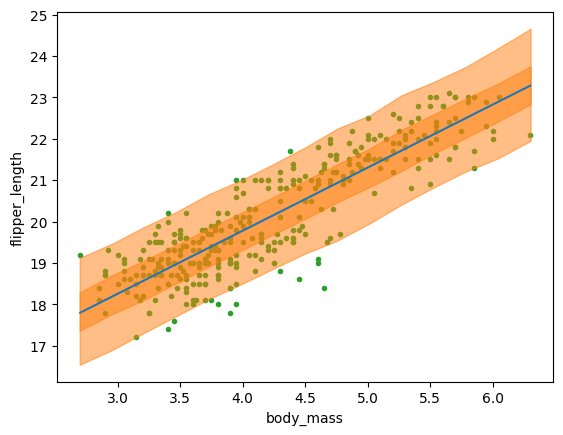

In [ ]:
mean_line = idata_peng.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
body_masses = np.random.normal(peng.body_mass.values, 0.01)
idx = np.argsort(body_masses)
x = np.linspace(body_masses.min(), body_masses.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_peng.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(body_masses[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(peng.body_mass, peng.flipper_length, "C2.", zorder=-3)
ax.plot(peng.body_mass.to_numpy()[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("body_mass")
ax.set_ylabel("flipper_length")


The mean line appears pretty spot on at the beginning, but becomes less and less accurate at the higher body masses as variance increases.

<Axes: xlabel='y_pred'>

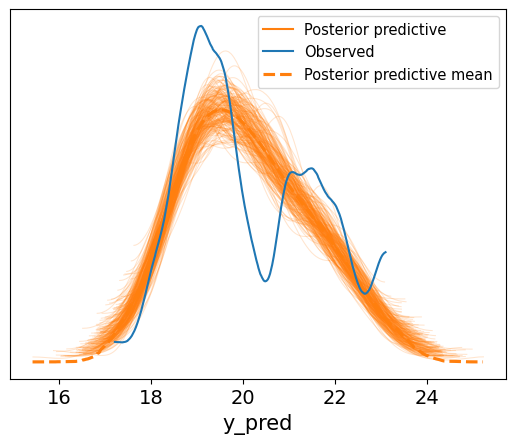

In [ ]:
az.plot_ppc(idata_peng, num_pp_samples=200, colors=["C1", "C0", "C1"])

Plotting the posterior reveals that there are alot more dips and peaks in my data that a normal distribution couldn't account for. This is likely because of anomolies in the data or because of the 3 different species present in the data and their different environmental requirements

Because the data is broken up by species, I'm using a categorical model so that it seperates the data by species which should help to even our the dips and peaks. Similar to the basketball example in the notes

In [ ]:
url_penguin = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
penguin = pd.read_csv(url_penguin,dtype={'species':'category'})

In [ ]:
penguin.dropna(inplace=True)

In [ ]:
penguin

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [ ]:
species_idx = penguin.species.cat.codes.values

#an array of the strings that represent species
species_codes = penguin.species.cat.categories

#puts coords in a dict, so pymc can read them
penguin_coords = {"spe": species_codes}

Breaks the scatter plots up by species, the category I assigned it above to split by

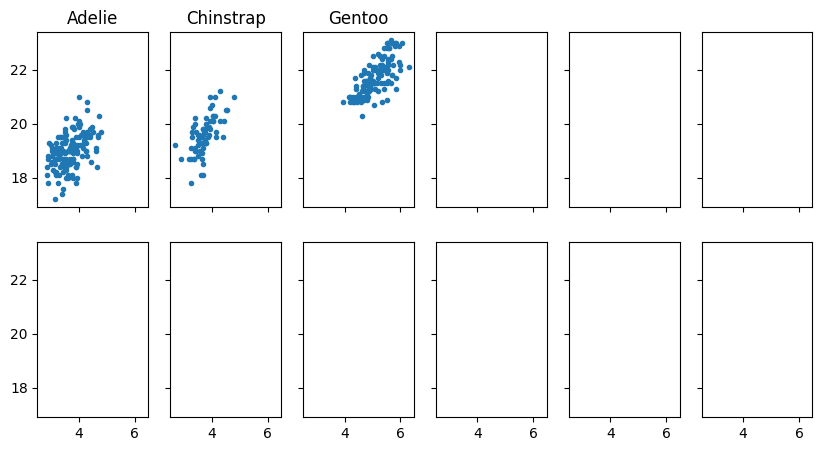

In [ ]:
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each species
for i, p in enumerate(species_codes):
    ax[i].scatter(
        x = penguin.query('species == @p')['body_mass'],
        y =  penguin.query('species == @p')['flipper_length'],
        marker=".")
    ax[i].set_title(f"{p}")

Used a normal distribution again, as it would give me more information when put into a categorical context

In [ ]:
with pm.Model(coords=penguin_coords) as penguin_model:
    #priors
    α = pm.Normal("α", mu=0, sigma=5, dims="spe")
    β = pm.Normal("β", mu=0, sigma=10, dims="spe")
    σ = pm.HalfNormal("σ", 5)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[species_idx] + β[species_idx] * penguin['body_mass'],
                  sigma=σ,
                  observed=penguin['flipper_length'])
    idata_penguin = pm.sample()

Output()

Output()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

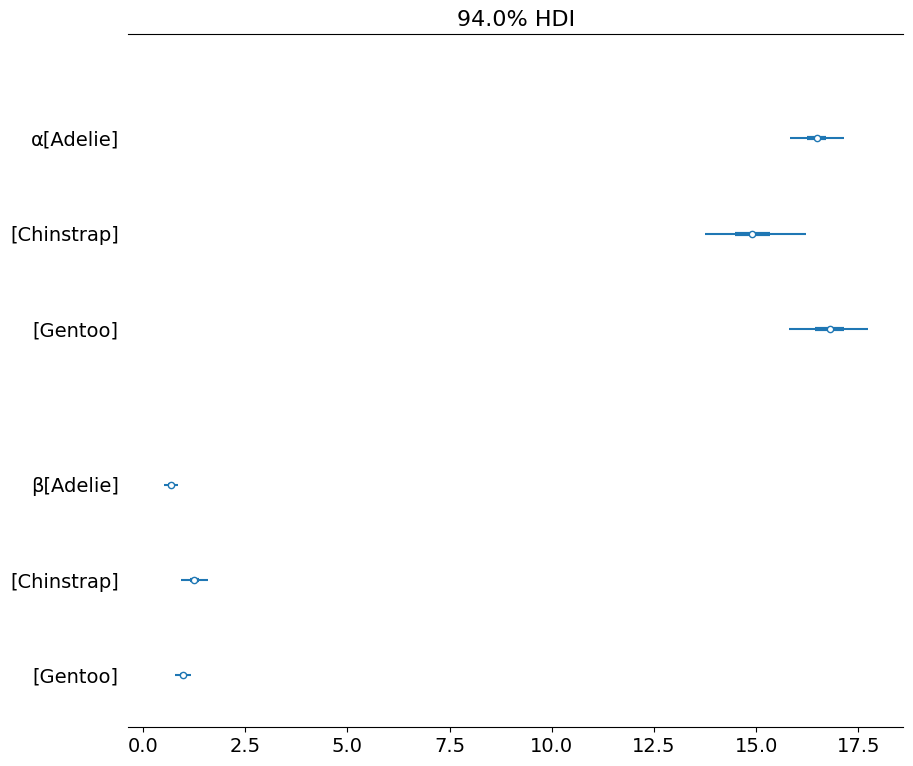

In [ ]:
az.plot_forest(idata_penguin, var_names=["α", "β"], combined=True, figsize=(10, 9))

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


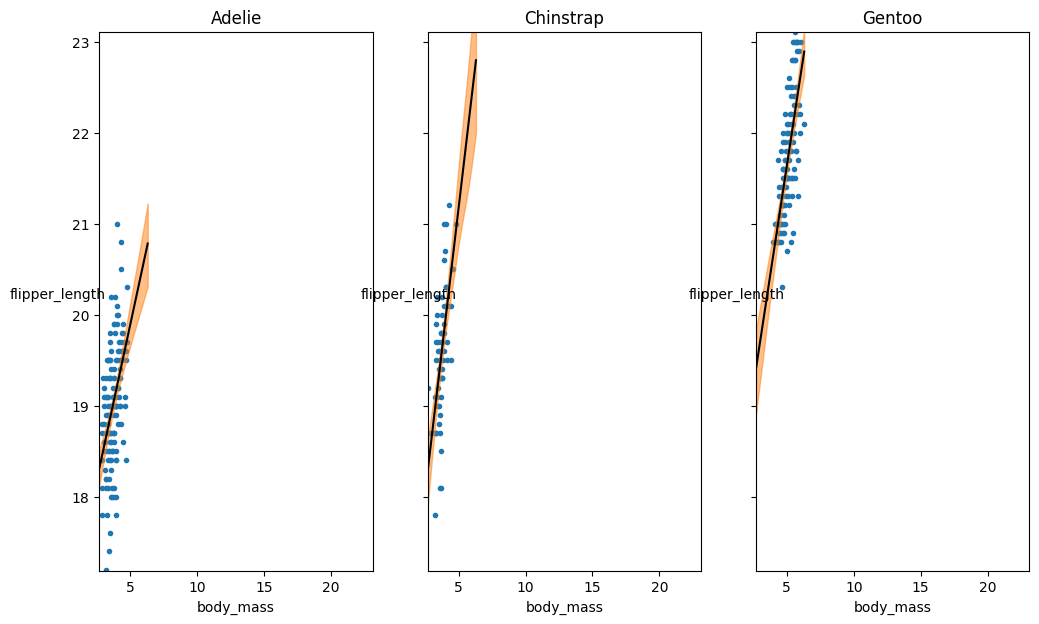

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(penguin['body_mass'].min(), penguin['body_mass'].max(), 10)

#grab posterior info
posterior = az.extract(idata_penguin)

#for each position
for i, p in enumerate(species_codes):
    #plot the raw data
    ax[i].scatter(
        x = penguin.query('species == @p')['body_mass'],
        y = penguin.query('species == @p')['flipper_length'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("body_mass")
    ax[i].set_ylabel("flipper_length", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(spe=p)
    betas = posterior["β"].sel(spe=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(penguin['body_mass'].min() - 0.01, penguin['flipper_length'].max() + 0.01)
    plt.ylim(penguin['flipper_length'].min() - 0.01, penguin['flipper_length'].max() + 0.01)

As you can see, the  model doesn't look too bad. However, this model is just doing it as a hierarchical model without forcing it to be linear, which is what this unit is all about which is what I'll do next

Adding the context of a linear regression model

In [ ]:
with pm.Model(coords=penguin_coords) as hoff_penguin_model:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=penguin['flipper_length'].mean(), sigma=5)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=10)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="spe")
    σ = pm.HalfNormal("σ", 5)

    #prior of beta is different; now, we predict how far our guess is from the
    #overall average
    β_offset = pm.Normal("β_offset", mu=0, sigma=5, dims="spe")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="spe")

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[species_idx] + β[species_idx] * penguin['body_mass'],
                  sigma=σ,
                  observed=penguin['flipper_length'])

    idata_hoff_penguin = pm.sample(target_accept = 0.99)

Output()

Output()

ERROR:pymc.stats.convergence:There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Small divergences in the data, but this could just be because of some anomolies in the data as they're animals and animals don't always follow the pattern in what they're meant to do.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

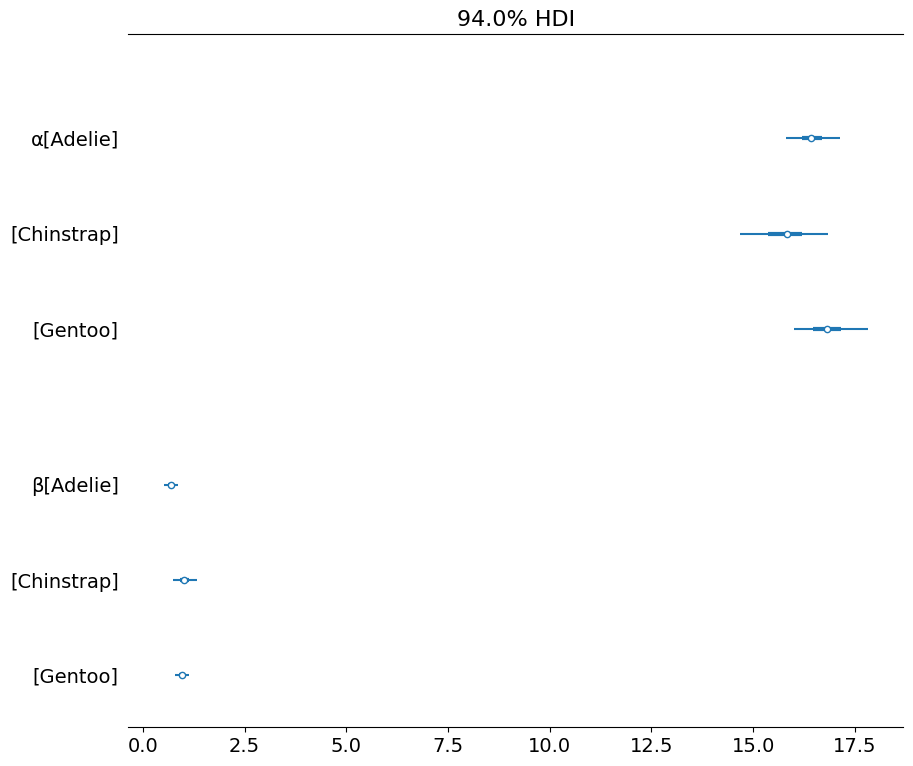

In [ ]:
az.plot_forest(idata_hoff_penguin, var_names=["α", "β"], combined=True, figsize=(10, 9))

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


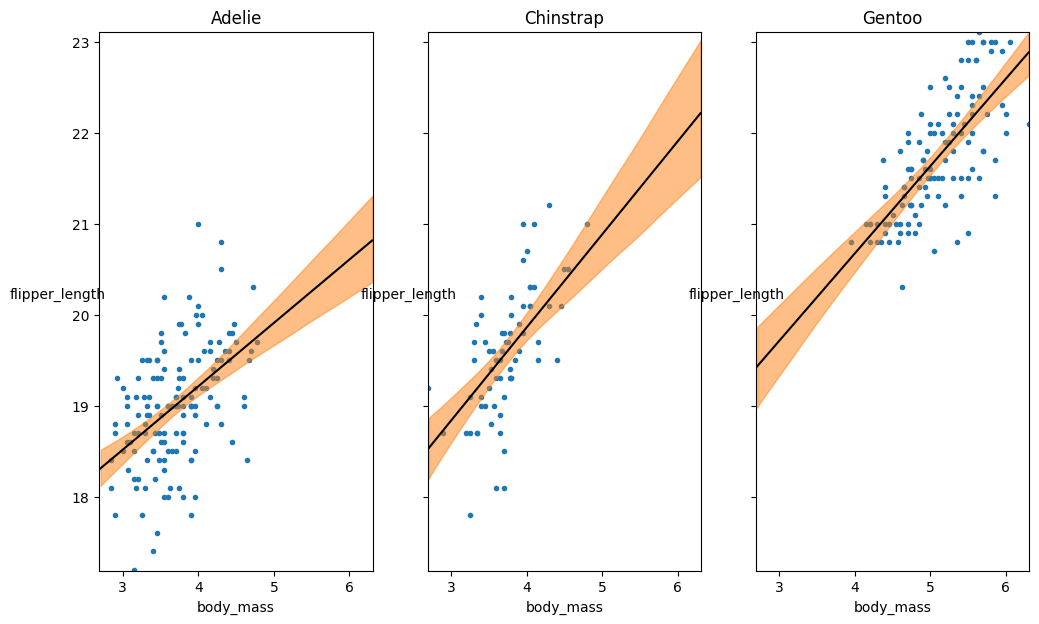

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)
#x values for putting through our linear equation, in order to graph the line
x_range = np.linspace(penguin['body_mass'].min(), penguin['body_mass'].max(), 10)
#grab the posterior
posterior = az.extract(idata_hoff_penguin)

for i, p in enumerate(species_codes):
    #plot raw data
    ax[i].scatter(
        x = penguin.query('species == @p')['body_mass'],
        y = penguin.query('species == @p')['flipper_length'],
        marker=".")
    #titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("body_mass")
    ax[i].set_ylabel("flipper_length", labelpad=10, rotation=0)
    #grab posterior info
    alphas = posterior["α"].sel(spe=p)
    betas = posterior["β"].sel(spe=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    #plot the posterior
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    #set window size
    plt.xlim(penguin['body_mass'].min() - 0.01, penguin['body_mass'].max() + 0.01)
    plt.ylim(penguin['flipper_length'].min() - 0.01, penguin['flipper_length'].max() + 0.01)

For my data set, this is where I stop instead of putting it all together on one model. Because of the different species represented by the data and the need to split them up by category, there's no easy way to put them all back together on the same model. The model starts to think I'm trying to make it 3D. Therefore, we'll just have to look at the accuracy of the model based on the scatter plots and posterior lines individually for each species.


Looking at the models, the posteriors appear to be going through the more populus areas of points. However, all the models have alot of variance in the data, so without a proper posterior predictive check, it's hard to know how accurate the model is. Since the model ran all the way through and the posteriors don't look too unimaginable as well as our previous knowledge leads us to believe that a linear model for this data isn't impossible, we can assume that by using a hierarchical linear regression model the model should be fairly ok.